# Visualization & community detection

In [28]:
import networkx as nx
import math

from cdlib import viz, algorithms
from cdlib.classes import NodeClustering
from collections import defaultdict

from stock_graph_creation import get_sp500_stocks, get_sp500_stocks_info
from stock_graph_creation import correlation_to_graph, correlation_to_pos_neg_graphs

In [ ]:
stocks_info = get_sp500_stocks_info()
correlations = get_sp500_stocks(start_date="2025-02-01", end_date="2025-03-01").corr()

In [13]:
G_pos, G_neg = correlation_to_pos_neg_graphs(correlations, stocks_info, threshold=0.7)

In [14]:
import matplotlib.pyplot as plt

def info(G, fast = False):
  print("{:>12s} | '{:s}'".format('Graph', G.name))

  n = G.number_of_nodes()
  m = G.number_of_edges()
  
  print("{:>12s} | {:,d} ({:,d})".format('Nodes', n, nx.number_of_isolates(G)))
  print("{:>12s} | {:,d} ({:,d})".format('Edges', m, nx.number_of_selfloops(G)))
  print("{:>12s} | {:.2f} ({:,d})".format('Degree', 2 * m / n, max([k for _, k in G.degree()])))

  if not fast:
    C = sorted(nx.connected_components(nx.MultiGraph(G)), key = len, reverse = True)

    print("{:>12s} | {:.1f}% ({:,d})".format('LCC', 100 * len(C[0]) / n, len(C)))

    print("{:>12s} | {:.4f}".format('Clustering', nx.average_clustering(G if type(G) == nx.Graph else nx.Graph(G))))
    
    C = algorithms.leiden(G)
    Q = C.newman_girvan_modularity().score
      
    print("{:>12s} | {:.4f} ({:,d})".format('Modularity', Q, len(C.communities)))
  print()

def plot_wiring_diagram(G, layout = None, C = None, S = None, label = "wiring", save_file = True):
  if layout is None:
    layout = nx.spring_layout(G)
    
  colors = None
  if C is not None:
    colors = [0] * len(G)
    for c, comm in enumerate(C.communities):
      for i in comm:
        colors[i] = c
    
  sizes = None
  if S is not None:
    sizes = [100 * len(G)] * len(G)
    for i in G.nodes():
      sizes[i] *= S[i]
  
  labels = {i: "" if G.nodes[i]['label'].isdigit() else G.nodes[i]['label'] for i in G.nodes()}
  
  plt.figure()

  nx.draw(G, pos = layout, node_color = colors, node_size = sizes, labels = labels, font_size = 5, edge_color = 'gray')
  
  if save_file:
    plt.savefig(G.name + "." + label + ".pdf", bbox_inches = 'tight')
  else:
    plt.show()
  plt.close()

def plot_block_model(G, C, save_file=False):
  plt.figure(figsize=(10, 10))
  
  C = sorted(C.communities, key = len)
  nodes = [i for c in C for i in c]
  A = nx.adjacency_matrix(G, nodelist = nodes).todense()
  
  plt.imshow(A, cmap = 'binary', interpolation = 'nearest')
  
  xy = 0
  for c in C[:-1]:
    xy += len(c)
    
    plt.plot([xy - 0.5, xy - 0.5], [-0.5, len(G) - 0.5], '-g')
    plt.plot([-0.5, len(G) - 0.5], [xy - 0.5, xy - 0.5], '-g')

  plt.yticks(range(len(G)), labels = [G.nodes[i]['label'] for i in nodes], size = 2)
  plt.xticks([])
  
  if save_file:
    plt.savefig(G.name + ".blocks.pdf", bbox_inches = 'tight')
  else:
    plt.show()
  plt.close()

In [15]:
info(G_pos)

       Graph | 'pos_correlations'
       Nodes | 502 (96)
       Edges | 1,313 (0)
      Degree | 5.23 (42)
         LCC | 74.7% (110)
  Clustering | 0.2374
  Modularity | 0.6515 (120)



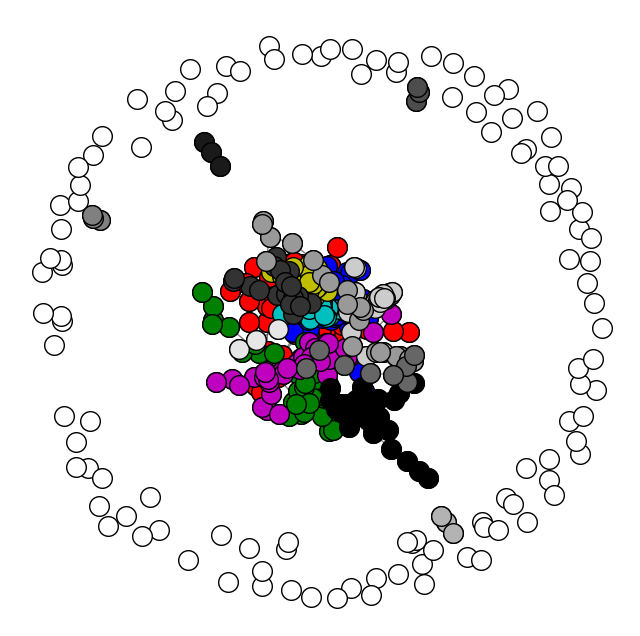

In [16]:
algs = {
    "Graph": lambda G: NodeClustering([range(len(G))],G, 'Graph'),
    "Isolates": lambda G: NodeClustering([[i] for i in range(len(G))], G, 'Isolates'),
    "MCL": algorithms.markov_clustering,
    "EMMM": lambda G: algorithms.em(G, k = 4), #expectation maximization
    "KL": lambda G: NodeClustering([list(c) for c in nx.community.kernighan_lin_bisection(G)], G, "KL"),
    "Louvain": lambda G: algorithms.louvain(G),
    "Leiden": lambda G: algorithms.leiden(G),
    "Infomap": lambda G: algorithms.infomap(G),
    "LP": lambda G: algorithms.label_propagation(G),
    "FLP": lambda G: NodeClustering([list(c) for c in nx.community.fast_label_propagation_communities(G)], G, "Fast LP")
}

    
viz.plot_network_clusters(G_pos, algs["Louvain"](G_pos), nx.spring_layout(G_pos))

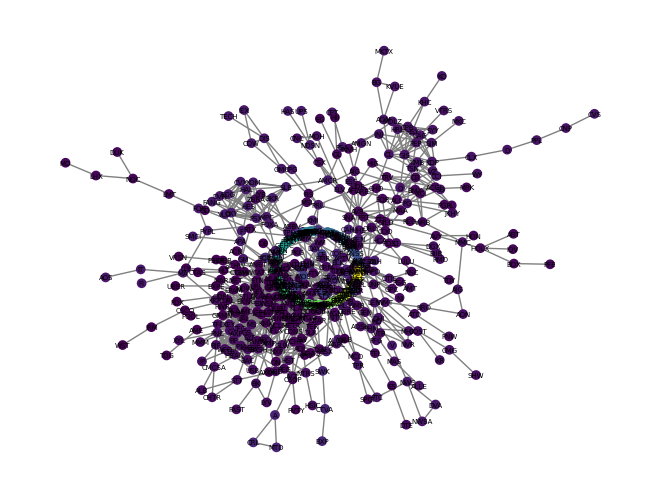

In [17]:
plot_wiring_diagram(G_pos, nx.kamada_kawai_layout(G_pos), algs["Leiden"](G_pos), save_file=False)

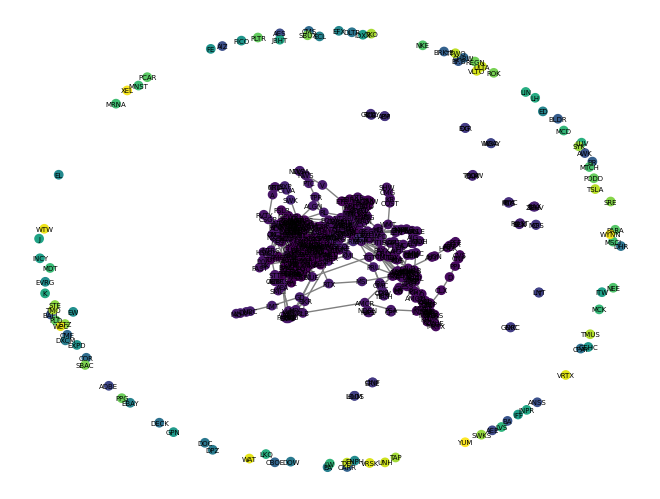

In [18]:
plot_wiring_diagram(G_pos, nx.forceatlas2_layout(G_pos), algs["Louvain"](G_pos), save_file=False)

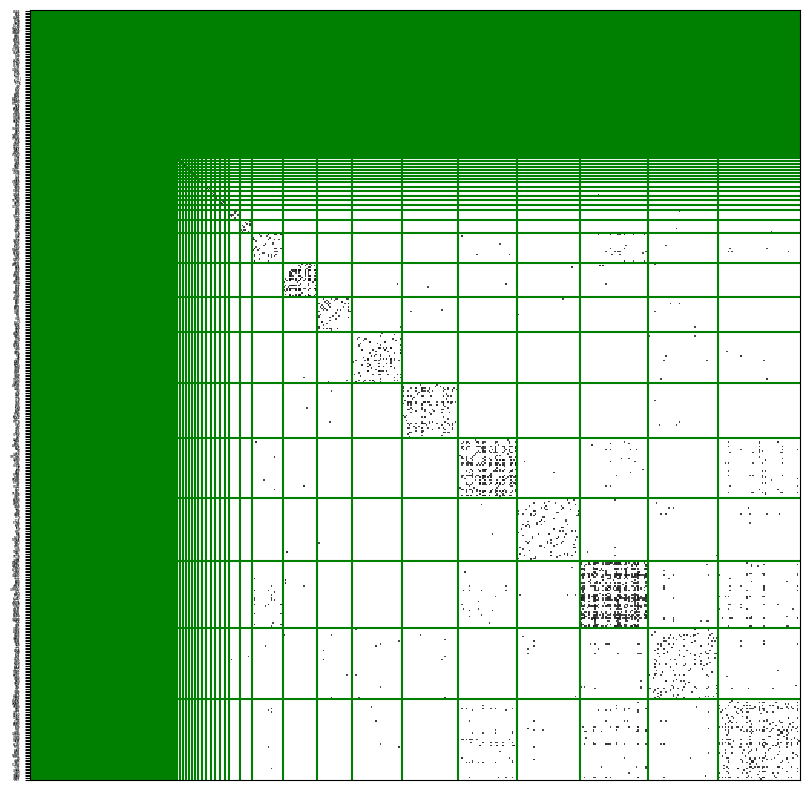

In [19]:
plot_block_model(G_pos, algs["Leiden"](G_pos), save_file=False)

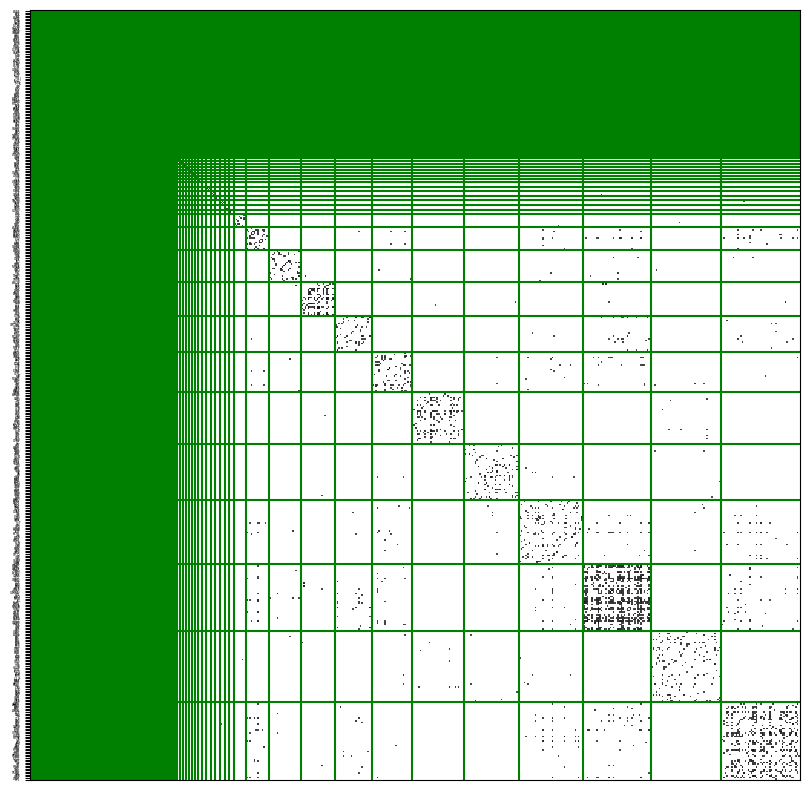

In [44]:
plot_block_model(G_pos, algs["Louvain"](G_pos), save_file=False)

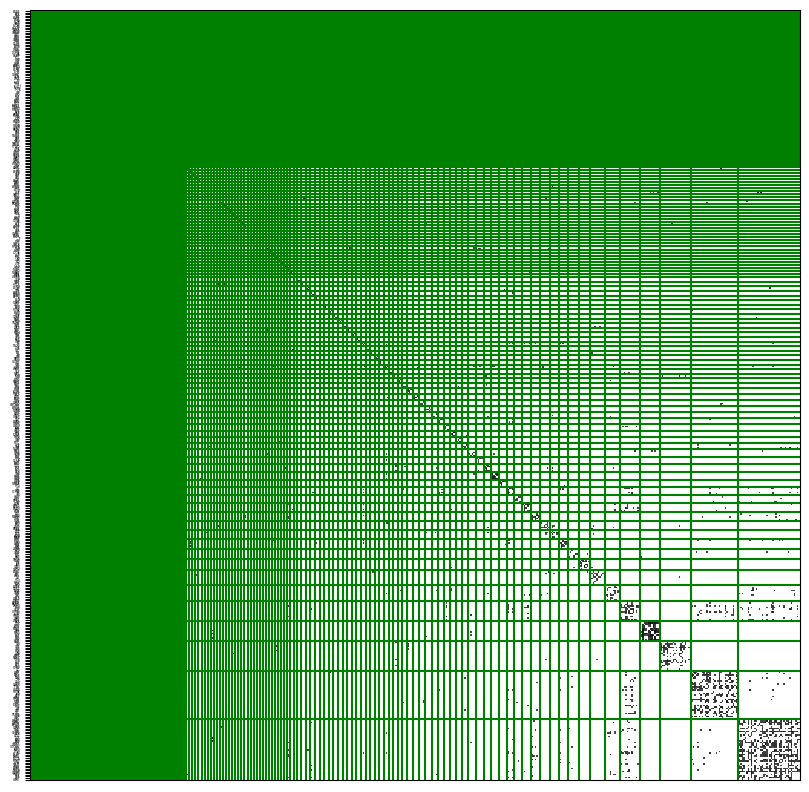

In [45]:
plot_block_model(G_pos, algs["MCL"](G_pos), save_file=False)

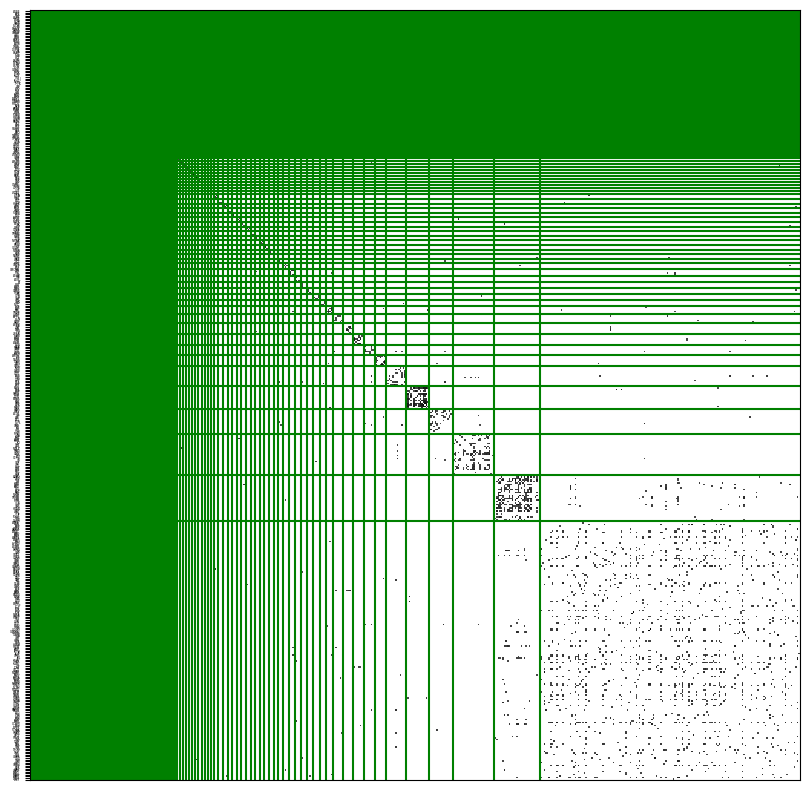

In [46]:
plot_block_model(G_pos, algs["FLP"](G_pos), save_file=False)

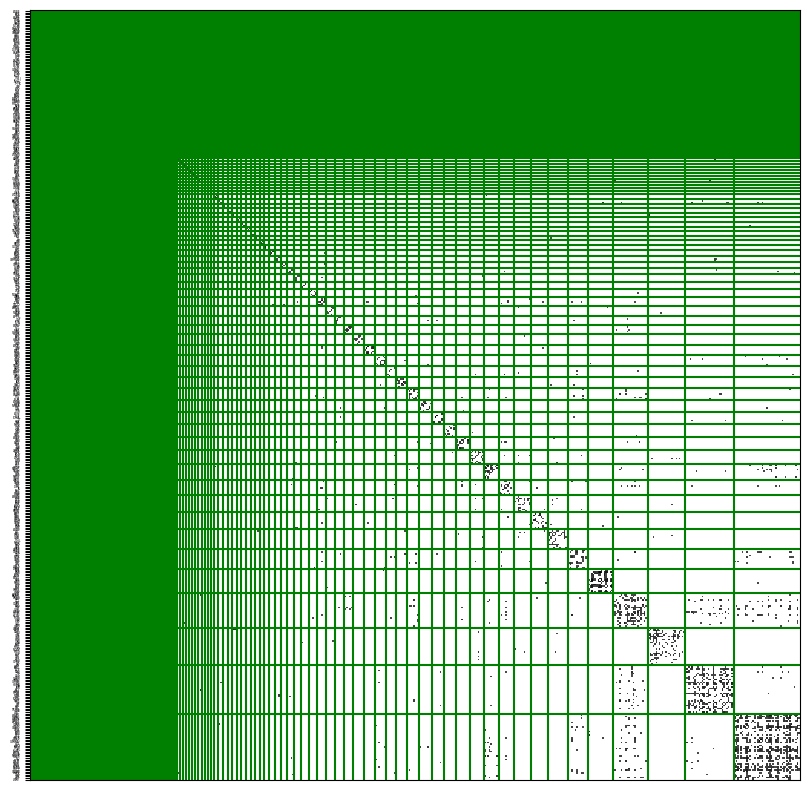

In [47]:
plot_block_model(G_pos, algs["Infomap"](G_pos), save_file=False)

There are visible communities. Let's investigate the communities more thoroughly and see which stocks are inside which communities.

In [21]:
communities = algs["Leiden"](G_pos).communities
len(communities)

121

In [22]:
for i, community in enumerate(communities):
    print(f"{i}: {len(community)} nodes")

0: 53 nodes
1: 48 nodes
2: 47 nodes
3: 46 nodes
4: 39 nodes
5: 37 nodes
6: 36 nodes
7: 22 nodes
8: 21 nodes
9: 20 nodes
10: 3 nodes
11: 3 nodes
12: 3 nodes
13: 3 nodes
14: 3 nodes
15: 3 nodes
16: 3 nodes
17: 2 nodes
18: 2 nodes
19: 2 nodes
20: 2 nodes
21: 2 nodes
22: 2 nodes
23: 2 nodes
24: 2 nodes
25: 1 nodes
26: 1 nodes
27: 1 nodes
28: 1 nodes
29: 1 nodes
30: 1 nodes
31: 1 nodes
32: 1 nodes
33: 1 nodes
34: 1 nodes
35: 1 nodes
36: 1 nodes
37: 1 nodes
38: 1 nodes
39: 1 nodes
40: 1 nodes
41: 1 nodes
42: 1 nodes
43: 1 nodes
44: 1 nodes
45: 1 nodes
46: 1 nodes
47: 1 nodes
48: 1 nodes
49: 1 nodes
50: 1 nodes
51: 1 nodes
52: 1 nodes
53: 1 nodes
54: 1 nodes
55: 1 nodes
56: 1 nodes
57: 1 nodes
58: 1 nodes
59: 1 nodes
60: 1 nodes
61: 1 nodes
62: 1 nodes
63: 1 nodes
64: 1 nodes
65: 1 nodes
66: 1 nodes
67: 1 nodes
68: 1 nodes
69: 1 nodes
70: 1 nodes
71: 1 nodes
72: 1 nodes
73: 1 nodes
74: 1 nodes
75: 1 nodes
76: 1 nodes
77: 1 nodes
78: 1 nodes
79: 1 nodes
80: 1 nodes
81: 1 nodes
82: 1 nodes
83: 

Lets slook at two largest communities.

### 1st largest community

In [23]:
community_1 = communities[0]
subgraph_1 = nx.induced_subgraph(G_pos, community_1)
info(subgraph_1)

       Graph | 'pos_correlations'
       Nodes | 53 (0)
       Edges | 357 (0)
      Degree | 13.47 (32)
         LCC | 100.0% (1)
  Clustering | 0.6104
  Modularity | 0.1847 (3)



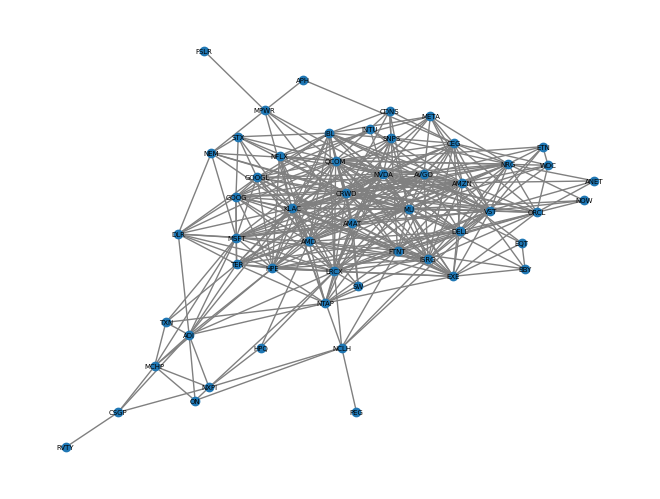

In [24]:
plot_wiring_diagram(subgraph_1, nx.forceatlas2_layout(subgraph_1), save_file=False)

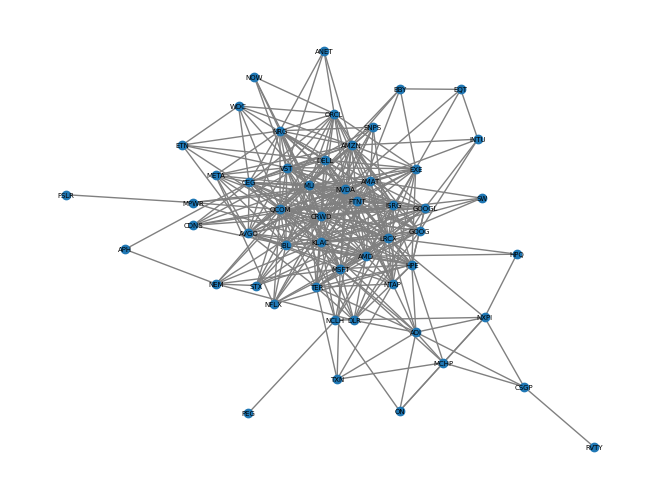

In [25]:
plot_wiring_diagram(subgraph_1, nx.kamada_kawai_layout(subgraph_1), save_file=False)

In [26]:
subgraph_1_labels = [data["label"] for _, data in subgraph_1.nodes(data=True)]
subgraph_1_labels

['DELL',
 'QCOM',
 'ADI',
 'DLR',
 'KLAC',
 'RVTY',
 'AMAT',
 'AMD',
 'SNPS',
 'LRCX',
 'AMZN',
 'ANET',
 'EQT',
 'STX',
 'APH',
 'SW',
 'ETN',
 'MCHP',
 'AVGO',
 'EXE',
 'META',
 'TER',
 'BBY',
 'MPWR',
 'FSLR',
 'FTNT',
 'MSFT',
 'TXN',
 'MU',
 'NCLH',
 'NEM',
 'NFLX',
 'GOOG',
 'GOOGL',
 'NOW',
 'CDNS',
 'NRG',
 'CEG',
 'NTAP',
 'NVDA',
 'VST',
 'NXPI',
 'ON',
 'HPE',
 'HPQ',
 'ORCL',
 'WDC',
 'PEG',
 'CRWD',
 'INTU',
 'CSGP',
 'ISRG',
 'JBL']

In [32]:
sectors_counts = defaultdict(int)
industries_counts = defaultdict(int)

for _, data in subgraph_1.nodes(data=True):
    sectors_counts[data["sector"]] += 1
    industries_counts[data["industry"]] += 1

sectors_counts

defaultdict(int,
            {'Information Technology': 33,
             'Real Estate': 2,
             'Health Care': 2,
             'Consumer Discretionary': 3,
             'Energy': 2,
             'Materials': 2,
             'Industrials': 1,
             'Communication Services': 4,
             'Utilities': 4})

In [33]:
industries_counts

defaultdict(int,
            {'Technology Hardware, Storage & Peripherals': 6,
             'Semiconductors': 12,
             'Data Center REITs': 1,
             'Semiconductor Materials & Equipment': 4,
             'Health Care Equipment': 2,
             'Application Software': 4,
             'Broadline Retail': 1,
             'Communications Equipment': 1,
             'Oil & Gas Exploration & Production': 2,
             'Electronic Components': 1,
             'Paper & Plastic Packaging Products & Materials': 1,
             'Electrical Components & Equipment': 1,
             'Interactive Media & Services': 3,
             'Computer & Electronics Retail': 1,
             'Systems Software': 4,
             'Hotels, Resorts & Cruise Lines': 1,
             'Gold': 1,
             'Movies & Entertainment': 1,
             'Independent Power Producers & Energy Traders': 1,
             'Electric Utilities': 3,
             'Real Estate Services': 1,
             'Electronic Man

Looks like overwhelming number of companies in this community are in the Information Technology sector.

### 2nd largest community

In [34]:
community_2 = communities[1]
subgraph_2 = nx.induced_subgraph(G_pos, community_2)
info(subgraph_2)

       Graph | 'pos_correlations'
       Nodes | 48 (0)
       Edges | 76 (0)
      Degree | 3.17 (9)
         LCC | 100.0% (1)
  Clustering | 0.2148
  Modularity | 0.5959 (6)



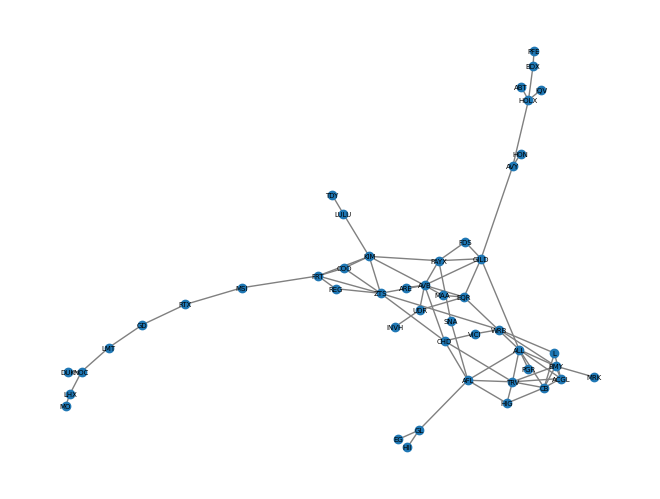

In [35]:
plot_wiring_diagram(subgraph_2, nx.forceatlas2_layout(subgraph_2), save_file=False)

In [36]:
subgraph_2_labels = [data["label"] for _, data in subgraph_2.nodes(data=True)]
subgraph_2_labels

['ABT',
 'ACGL',
 'REG',
 'KIM',
 'AFL',
 'DUK',
 'RTX',
 'L',
 'ALL',
 'LHX',
 'EG',
 'SNA',
 'LMT',
 'LULU',
 'EQR',
 'MAA',
 'ARE',
 'AVB',
 'AVY',
 'TDY',
 'FDS',
 'BDX',
 'MO',
 'MRK',
 'FRT',
 'TRV',
 'BMY',
 'GD',
 'MSI',
 'GILD',
 'UDR',
 'GL',
 'CB',
 'NOC',
 'VICI',
 'CHD',
 'HIG',
 'HII',
 'HOLX',
 'HON',
 'COO',
 'PAYX',
 'WRB',
 'PFE',
 'PGR',
 'INVH',
 'IQV',
 'ZTS']

In [37]:
sectors_counts = defaultdict(int)
industries_counts = defaultdict(int)

for _, data in subgraph_2.nodes(data=True):
    sectors_counts[data["sector"]] += 1
    industries_counts[data["industry"]] += 1

sectors_counts

defaultdict(int,
            {'Health Care': 10,
             'Financials': 12,
             'Real Estate': 10,
             'Utilities': 1,
             'Industrials': 9,
             'Consumer Discretionary': 1,
             'Materials': 1,
             'Information Technology': 2,
             'Consumer Staples': 2})

In [38]:
industries_counts

defaultdict(int,
            {'Health Care Equipment': 3,
             'Property & Casualty Insurance': 7,
             'Retail REITs': 3,
             'Life & Health Insurance': 2,
             'Electric Utilities': 1,
             'Aerospace & Defense': 6,
             'Multi-line Insurance': 1,
             'Reinsurance': 1,
             'Industrial Machinery & Supplies & Components': 1,
             'Apparel, Accessories & Luxury Goods': 1,
             'Multi-Family Residential REITs': 4,
             'Office REITs': 1,
             'Paper & Plastic Packaging Products & Materials': 1,
             'Electronic Equipment & Instruments': 1,
             'Financial Exchanges & Data': 1,
             'Tobacco': 1,
             'Pharmaceuticals': 4,
             'Communications Equipment': 1,
             'Biotechnology': 1,
             'Hotel & Resort REITs': 1,
             'Household Products': 1,
             'Industrial Conglomerates': 1,
             'Health Care Supplies': 1,
  

This is a more diverse community: equal number of Health Care, Financials and Real Estate.

In [41]:
def clustering(G, cluster_def):
  C = {}
  for i, data in G.nodes(data = True):
    c = data[cluster_def]
    if c not in C:
      C[c] = []
    C[c].append(i)
    
  return NodeClustering(list(C.values()), G, 'Known')
  
def comparison(G, algs, runs = 1, cluster_def='sector'):
  K = clustering(G, cluster_def)
  
  print("{:>12s} | {:>7s} {:^6s}  {:^5s}  {:^5s}  {:^5s}".format('Algorithm', 'Count', 'Q', 'NMI', 'ARI', 'NVI'))
  
  for alg in algs:
    s, Q, NMI, ARI, NVI = 0, 0, 0, 0, 0
    
    for _ in range(runs):
      C = algs[alg](G)
      s += len(C.communities) / runs
      Q += C.newman_girvan_modularity().score / runs
      NMI += K.normalized_mutual_information(C).score / runs
      ARI += K.adjusted_rand_index(C).score / runs
      NVI += K.variation_of_information(C).score / math.log(len(G)) / runs
      
    print("{:>12s} | {:>7.1f} {:6.3f}  {:5.3f}  {:5.3f}  {:5.3f}".format('\'' + alg + '\'', s, Q, NMI, ARI, NVI))
  print()

In [42]:
comparison(G_pos, algs, runs = 1, cluster_def="sector")

   Algorithm |   Count   Q      NMI    ARI    NVI 
     'Graph' |     1.0  0.000  0.000  0.000  0.534
  'Isolates' |   502.0 -0.005  0.540  0.000  0.909
       'MCL' |   193.0  0.546  0.472  0.088  0.861
      'EMMM' |     4.0  0.051  0.039  0.002  0.706
        'KL' |     2.0  0.299  0.036  0.019  0.670
   'Louvain' |   120.0  0.651  0.368  0.119  0.840
    'Leiden' |   121.0  0.650  0.369  0.122  0.849
   'Infomap' |   152.0  0.619  0.431  0.110  0.873
        'LP' |   158.0  0.444  0.431  0.101  0.807
       'FLP' |   141.0  0.517  0.420  0.113  0.792



In [43]:
comparison(G_pos, algs, runs = 1, cluster_def="industry")

   Algorithm |   Count   Q      NMI    ARI    NVI 
     'Graph' |     1.0  0.000  0.000  0.000  1.056
  'Isolates' |   502.0 -0.005  0.845  0.000  0.387
       'MCL' |   193.0  0.546  0.748  0.120  0.542
      'EMMM' |     4.0  0.084  0.179  0.007  1.090
        'KL' |     2.0  0.319  0.131  0.008  1.058
   'Louvain' |   121.0  0.649  0.606  0.069  0.735
    'Leiden' |   121.0  0.653  0.601  0.065  0.744
   'Infomap' |   154.0  0.617  0.712  0.124  0.593
        'LP' |   158.0  0.444  0.660  0.039  0.659
       'FLP' |   143.0  0.535  0.642  0.045  0.682



Looks like both the Sector and Sub-Industry values somewhat correspond with detected communities.